## SIMULATION OF SEIR INFECTIOUS DISEASE MODEL FOR COVID-19


The beta = `Mean infection count`/population, where Mean infection count is the new infected mean of simulated gamma using MCMC.

The 

### Content:
1. China Total
2. Ex-Hubei
3. Hubei
4. Ex-China

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
from math import *
import datetime
import matplotlib.dates as mdates
from Dynamic_SEIR_model import *
from SEIR_model import SEIR
from helper_fun_epi_model import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Some assumptions
China_population = 1400000000
Hubei_population = 58500000

### Load data and clean data

In [3]:
## Load data 
df = pd.read_csv("../data/DXYArea.csv")

"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] > datetime.datetime(2019, 12, 7)]  # first day is 2019-12-08
df = df[df['date'] != df['date'].max()] # remove todays' records (since it can be incompleted)
df = df[df['date'] <= datetime.datetime(2020, 2, 22)]  # until 2020-02-22

In [4]:
## Dataset preperation
df['R'] = df['cured'] + df['dead']
SIR_data = df[['date', 'Days', 'countryCode','province', 'city', 'net_confirmed', 'suspected', 'R', 
              ]].rename(columns={"net_confirmed": "I", "suspected": "E"})
#SIR_data.tail(3)

### Estimate China Total

In [5]:
# China total

# Use data before 2020-02-14 for train model
China_df = SIR_data[SIR_data['date'] < datetime.datetime(2020, 2, 14)] 
China_total = get_China_total(China_df)
China_total.tail(2)

,date,Days,countryCode,province,city,I,E,R
6436,2020-02-12,66,CN,NaN,NaN,51933,13435,6906
6781,2020-02-13,67,CN,NaN,NaN,55823,10109,8109


In [6]:
## use the observation（2020-02-13）as the initial point in the new SEIR model
## the test data is from 2020-02-14-2020-02-22
population = China_population
# I is the net confirmed cases (total confirmed case - heal - died)
I0 = list(China_total['I'])[-1]
R0 = list(China_total['R'])[-1]
# suppose the total number of individuals within incubation period is 4 time of current suscepted cases
E0 = list(China_total['E'])[-1] *4
S0 = population - I0 - E0 - R0

In [7]:
est_beta = 2265.6/China_population # based on MCMC result
population = China_population

Maximum infected case:  58517


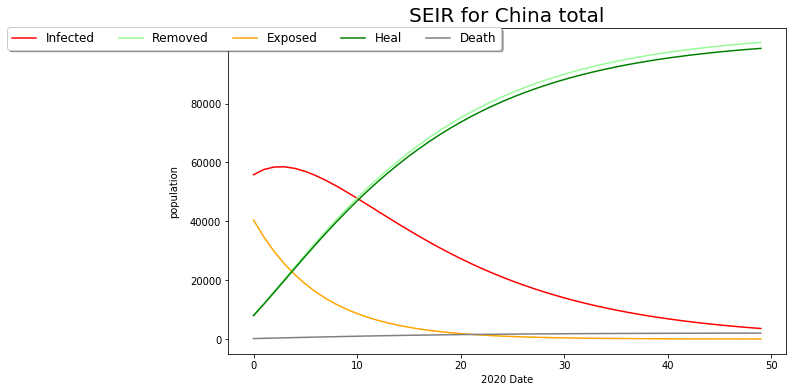

In [8]:
result = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=China_population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for China total', death_rate=0.02, show_Sus = False)

The MAMPE is: 
0.006409553958422852


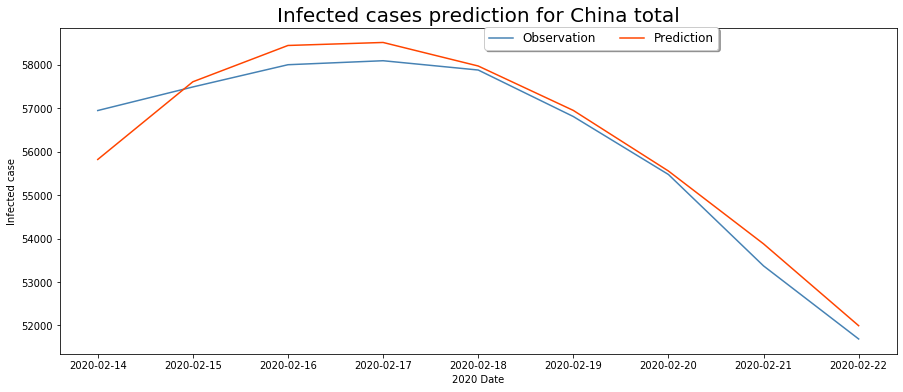

In [9]:
"""
Calculate MAPE test score using SEIR model result
"""
test = get_China_total(SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)])
plot_test_data_with_MAPE(test, result, 'Infected cases prediction for China total')

### Estimate Ex-Hubei

Maximum infected case:  9017


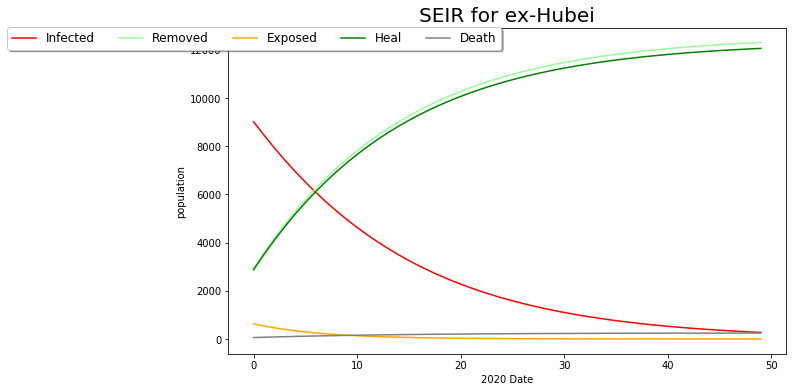

The MAMPE is: 
0.024703801501109946


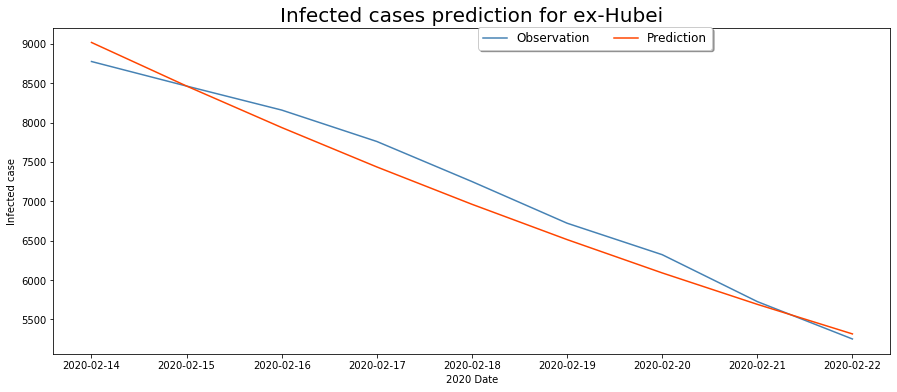

In [12]:
NotHubei = get_China_exclude_province(China_df, "Hubei Province")

NotHubei["E"] = NotHubei["E"] * 1/4 # suppose the number of exposed cases outside Hubei


population = China_population - Hubei_population
est_beta = 408.2/population # based on MCMC result


## use the last observation as the initial point in the new SEIR model
I0 = list(NotHubei['I'])[-1]
R0 = list(NotHubei['R'])[-1]
E0 = list(NotHubei['E'])[-1] * 1/4 # suppose the number of exposed cases outside Hubei
S0 = population - I0 - E0 - R0

result2 = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for ex-Hubei', death_rate=0.02, show_Sus = False)

"""
Calculate MAPE test score using SEIR model result
"""
China_df_test = SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)] 
test = get_China_exclude_province(China_df_test, "Hubei Province")
plot_test_data_with_MAPE(test, result2, 'Infected cases prediction for ex-Hubei')

## Estimate Hubei 
Which is equal China total - Ex-Hubei


The MAMPE is: 
0.01071033415707139


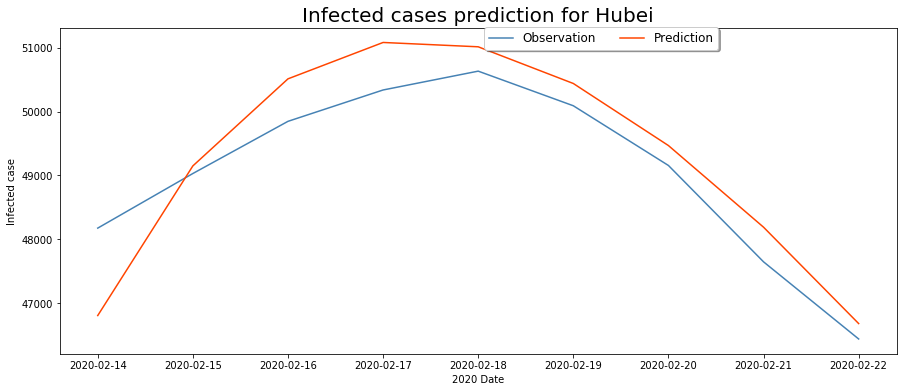

In [13]:
## data process
Hubei = get_province_df(China_df, "Hubei Province")
del Hubei['E']
Hubei  = pd.merge(Hubei, NotHubei[['date','E']], on='date')
Hubei["E"] = NotHubei["E"] * 3/4 # suppose the number of exposed cases inside Hubei

## estimted result 
result_Hubei = result - result2

China_df_test = SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)] 
test = get_province_df(China_df_test, "Hubei Province")

plot_test_data_with_MAPE(test, result_Hubei,'Infected cases prediction for Hubei')

### Estimate Ex-China
Use JHU dataset

In [15]:
world_population = 7000000000 - China_population # assumption
population = world_population
est_beta = 51.2/population # based on MCMC result

Maximum infected case:  453


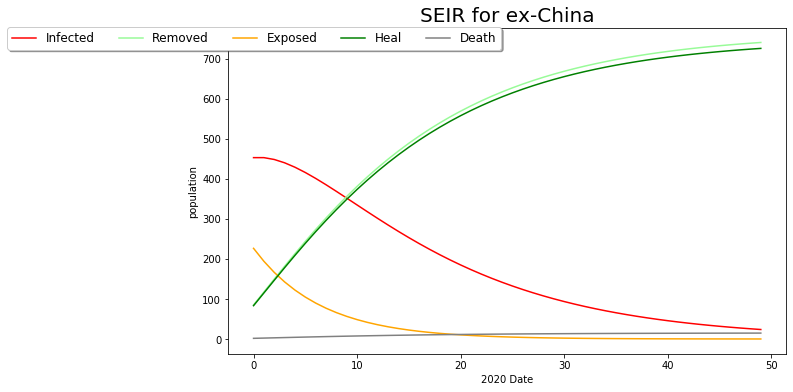

The MAMPE is: 
0.45816757485341103


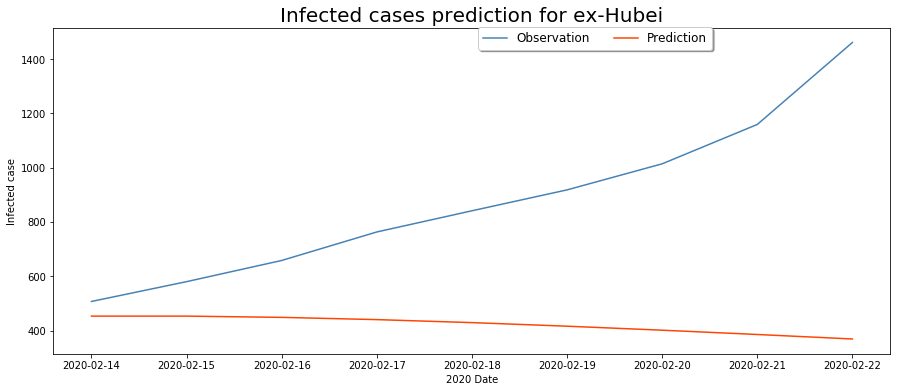

In [16]:
## Load data 
df = pd.read_csv("../data/daily_time_series_data_JHU.csv").rename(columns={"Date": "date"})

"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

first_day = datetime.datetime(2019, 12, 8) # the time when detected the first case (2019-12-08)
df['Days'] = (df['date'] - first_day).dt.days

## Dataset preperation
df['R'] = df['Deaths'] + df['Recovered']
df["I"] = df['Confirmed'] - df['R'] # net confirmed case
SIR_data = df[['date', 'Days','Country','Province','I','R']]
Sum_country = SIR_data.groupby(['Country','date','Days'])['I', 'R'].sum().reset_index()

NotChina_df = SIR_data[SIR_data['Country'] != 'China']
NotChina_df = NotChina_df.groupby(['date','Days'])['I', 'R'].sum().reset_index()
# ex-China total
# Use data before 2020-02-14 for train model
NotChina = NotChina_df[NotChina_df['date'] < datetime.datetime(2020, 2, 14)] 


"""
parameter for SEIR model
"""
## use the last observation as the initial point in the new SEIR model
I0 = list(NotChina['I'])[-1]
R0 = list(NotChina['R'])[-1]
E0 = list(NotChina['I'])[-1] * 1/2 # suppose the number of exposed cases outside China
S0 = population - I0 - E0 - R0

result3 = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for ex-China', death_rate=0.02, show_Sus = False)

"""
Calculate MAPE test score using SEIR model result
"""
test = NotChina_df[NotChina_df['date'] >= datetime.datetime(2020, 2, 14)] 
plot_test_data_with_MAPE(test, result3, 'Infected cases prediction for ex-Hubei')